In [1]:
import numpy as np
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from collections import OrderedDict

/home/eecs/jialin_song/anaconda3/envs/round_11/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparation

In [2]:
MODEL_FILEDIR = '/scratch/data/TrojAI/cyber-pdf-dec2022-train/models/'
METADATA_FILEPATH = '/scratch/data/TrojAI/cyber-pdf-dec2022-train/METADATA.csv'
MODEL_NUM = 120
# MODEL_ARCH = ['classification:' + arch for arch in ['resnet50', 'vit_base_patch32_224', 'mobilenet_v2']]
# OUTPUT_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/extracted_source/'


def num_to_model_id(num):
    return 'id-' + str(100000000+num)[1:]

# Load Metadata

In [3]:
METADATA = pd.read_csv(METADATA_FILEPATH)
METADATA.head()

,model_name,data_split,ground_truth,poisoned,poisoned_level,arch_level,nn_layers_level,nn_activation_function_level,svm_kernel_level,rf_trees_level,...,prepoison-unwatermarked-benign-support,prepoison-unwatermarked-malicious-precision,prepoison-unwatermarked-malicious-recall,prepoison-unwatermarked-malicious-f1-score,prepoison-unwatermarked-malicious-support,prepoison-watermarked-accuracy,prepoison-watermarked-malicious-precision,prepoison-watermarked-malicious-recall,prepoison-watermarked-malicious-f1-score,prepoison-watermarked-malicious-support
0,id-00000000,train,0,False,0,0,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id-00000001,train,1,True,1,0,5,0,NaN,NaN,...,2250.0,0.996365,0.998179,0.997271,2746.0,0.000000,0.0,0.000000,0.000000,1215.0
2,id-00000002,train,1,True,1,0,4,0,NaN,NaN,...,2250.0,0.996000,0.997451,0.996725,2746.0,0.378422,1.0,0.378422,0.549065,1242.0
3,id-00000003,train,1,True,1,0,3,0,NaN,NaN,...,2250.0,0.997450,0.997087,0.997268,2746.0,1.000000,1.0,1.000000,1.000000,1265.0
4,id-00000004,train,1,True,1,0,2,0,NaN,NaN,...,2250.0,0.992764,0.999272,0.996007,2746.0,0.021721,1.0,0.021721,0.042518,1197.0


In [24]:
clean_exmp_data_dirpath = '/scratch/data/TrojAI/cyber-pdf-dec2022-train/models/id-00000001/clean-example-data'
poisoned_exmp_data_dirpath = '/scratch/data/TrojAI/cyber-pdf-dec2022-train/models/id-00000001/clean-example-data'#'/scratch/data/TrojAI/cyber-pdf-dec2022-train/models/id-00000001/poisoned-example-data'

In [25]:
poisoned_data, poisoned_label = [], []
for poisoned_data_filepath in os.listdir(poisoned_exmp_data_dirpath):
    if poisoned_data_filepath.endswith('.npy'):
        p_data = np.load(os.path.join(poisoned_exmp_data_dirpath, poisoned_data_filepath))
        poisoned_data.append(p_data)
        with open(os.path.join(poisoned_exmp_data_dirpath, poisoned_data_filepath+'.json'), 'r') as label_file:
            poisoned_label.append(json.load(label_file))

In [30]:
poisoned_data = np.asarray(poisoned_data)

In [31]:
poisoned_data.max(), poisoned_data.min()

(200434000000.0, -1236895364.0)

# Feature Extraction

## Aggregated Weight

In [49]:
def extract_weight(model_repr : dict, layer_ind=[0, 1, -2, -1], axis=0):
    params = []
    od_keys = [k for k in model_repr.keys()]
    for ind in layer_ind:
        param = model_repr[od_keys[ind]]
        if len(param.shape) > 1:
            params += np.amax(param, axis=axis).tolist()
            params += np.mean(param, axis=axis).tolist()
            sub = np.mean(param, axis=axis) - np.median(param, axis=axis)
            params += sub.tolist()
            params += np.median(param, axis=axis).tolist()
            params += np.sum(param, axis=axis).tolist()
            params.append(np.linalg.norm(param, ord='fro')**2/np.linalg.norm(param, ord=2)**2)
        else:
            params.append(param.max().tolist())
            params.append(param.mean().tolist())
            sub = param.mean() - np.median(param)
            params.append(sub.tolist())
            params.append(np.median(param).tolist())
            params.append(param.sum().tolist())
            params.append((np.linalg.norm(param.reshape(param.shape[0], -1), ord='fro')**2/np.linalg.norm(param.reshape(param.shape[0], -1), ord=2)**2).tolist())
    return params

In [36]:
model_num = 0
model_id = num_to_model_id(model_num)
model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
model = torch.load(model_filepath)
model_repr = OrderedDict({layer: tensor.numpy() for (layer, tensor) in model.state_dict().items()})

p = extract_weight(model_repr)

In [11]:
p.shape

(1189,)

In [9]:
135*5+1+6+501+6

1189

In [4]:
X, y = [], []
for model_num in tqdm(range(MODEL_NUM)):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    model = torch.load(model_filepath)
    model_repr = OrderedDict({layer: tensor.numpy() for (layer, tensor) in model.state_dict().items()})

    reversed_order_key = [k for k in model_repr.keys() if 'weight' in k][:-1][::-1]
    
    weight = None
    for rk in reversed_order_key:
        weight = model_repr[rk] if weight is None else (weight @ model_repr[rk]) 
    # p = weight
    
    _, s, _ = np.linalg.svd(weight.T.reshape(135, 10, 10))
    p = s.flatten()
    
    # p = []
    # axis = 0
    # p += np.amax(weight, axis=axis).tolist()
    # p += np.mean(weight, axis=axis).tolist()
    # sub = np.mean(weight, axis=axis) - np.median(weight, axis=axis)
    # p += sub.tolist()
    # p += np.median(weight, axis=axis).tolist()
    # p += np.sum(weight, axis=axis).tolist()
    # p.append(np.linalg.norm(weight, ord='fro')**2/np.linalg.norm(weight, ord=2)**2)

    # p.append(weight.max().tolist())
    # p.append(weight.mean().tolist())
    # sub = weight.mean() - np.median(weight)
    # p.append(sub.tolist())
    # p.append(np.median(weight).tolist())
    # p.append(weight.sum().tolist())
    # p.append(np.linalg.norm(weight, ord='fro')**2/np.linalg.norm(weight, ord=2)**2)

    # p = weight.flatten().tolist()

    poisoned = METADATA[METADATA['model_name'] == model_id]['poisoned'].item()

    X.append(p)
    y.append(poisoned)
X = np.asarray(X)

100%|██████████| 120/120 [00:02<00:00, 56.78it/s]


In [5]:
X.shape

(120, 1350)

In [4]:
weight_dict_X, weight_dict_y = [], []
for model_num in tqdm(range(MODEL_NUM)):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    model = torch.load(model_filepath)
    model_repr = OrderedDict({layer: tensor.numpy() for (layer, tensor) in model.state_dict().items()})

    reversed_order_key = [k for k in model_repr.keys() if 'weight' in k][:-1][::-1]
    
    weight = None
    for rk in reversed_order_key:
        weight = model_repr[rk] if weight is None else (weight @ model_repr[rk]) 
    p = weight

    # bias = []
    # bias_key = [k for k in model_repr.keys() if 'bias' in k][:-1]
    # for bk in bias_key:
    #     bias.append(model_repr[bk])
    # bias = np.mean(bias, axis=0)

    # p = extract_weight(model_repr, layer_ind=[0, 1])
    # p += weight.flatten().tolist()
    # p += bias.tolist()

    poisoned = METADATA[METADATA['model_name'] == model_id]['poisoned'].item()

    weight_dict_X.append(p)
    weight_dict_y.append(poisoned)
weight_dict_X = np.asarray(weight_dict_X)

100%|██████████| 120/120 [00:01<00:00, 72.73it/s]


In [5]:
weight_dict_X.shape

(120, 100, 135)

In [8]:
trojan_model_ids = [ind for ind in METADATA[METADATA['poisoned']].index]
clean_model_ids = [ind for ind in METADATA[METADATA['poisoned'] == False].index]

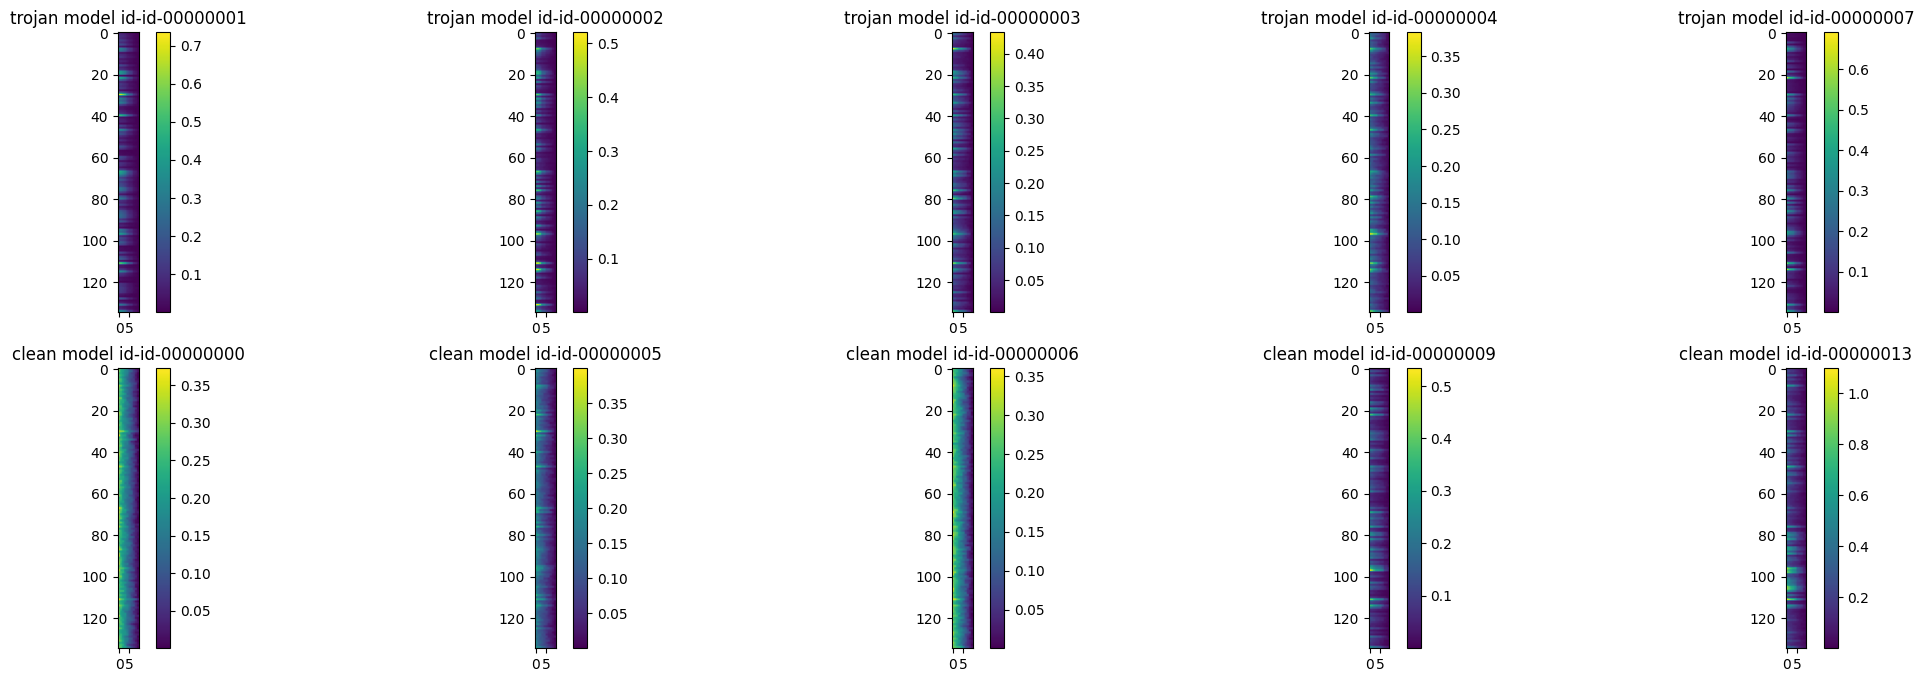

In [11]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(26, 8))
ids = trojan_model_ids[:5] + clean_model_ids[:5]
vmins, vmaxs = None, None #np.amin(X[ids]), np.amax(X[ids])
for i in range(5):
    img1 = axs[0, i].imshow(X[trojan_model_ids[i]].reshape(135, 10), vmin=vmins, vmax=vmaxs)
    img2 = axs[1, i].imshow(X[clean_model_ids[i]].reshape(135, 10), vmin=vmins, vmax=vmaxs)
    axs[0, i].set_title(f'trojan model id-{num_to_model_id(trojan_model_ids[i])}')
    axs[1, i].set_title(f'clean model id-{num_to_model_id(clean_model_ids[i])}')
    plt.colorbar(img1, ax=axs[0, i])
    plt.colorbar(img2, ax=axs[1, i])

In [13]:
axis = 1 #(1, 2)
normalized_weights = (X - np.amin(X, axis=axis, keepdims=True))/(np.amax(X, axis=axis, keepdims=True)- np.amin(X, axis=axis, keepdims=True))

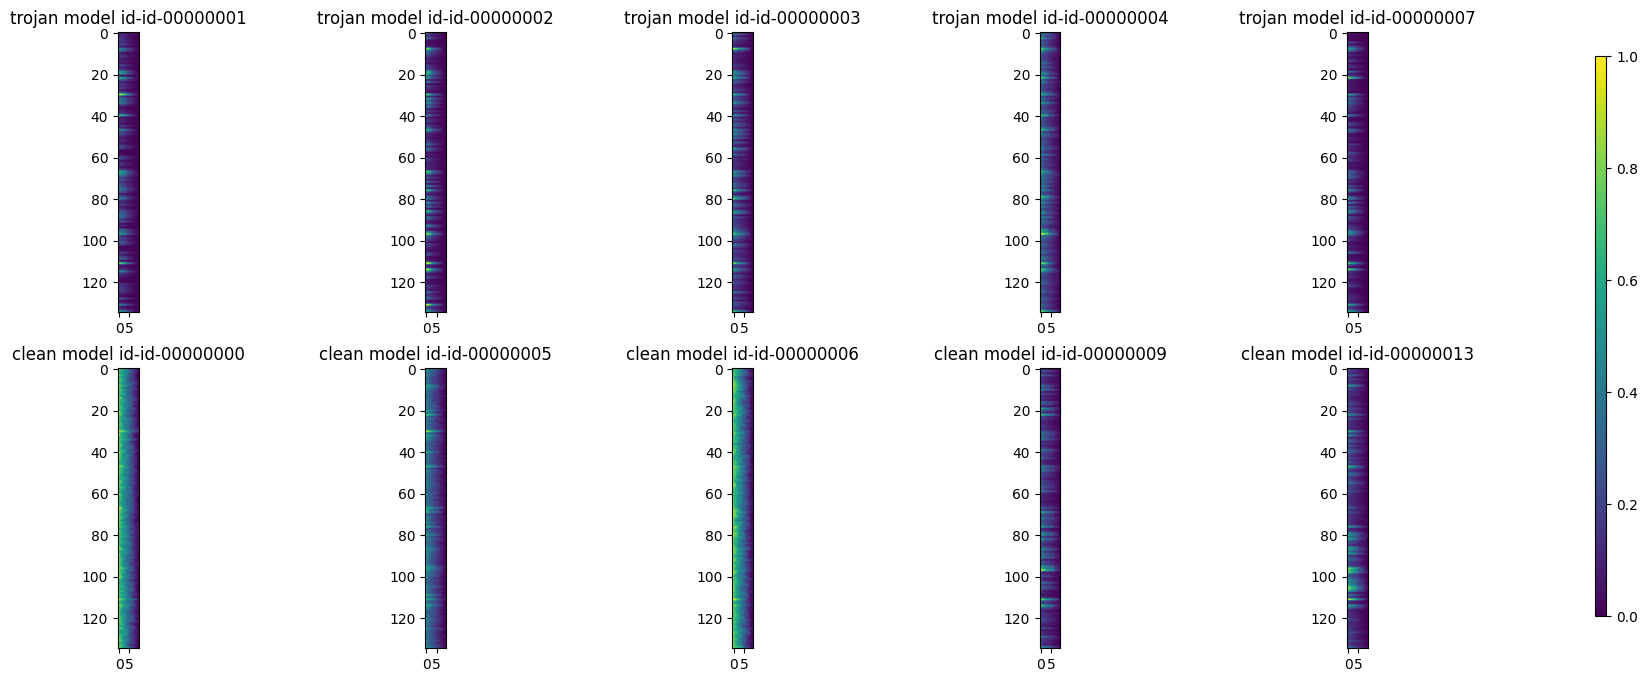

In [30]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 8))
ids = trojan_model_ids[:5] + clean_model_ids[:5]
vmins, vmaxs = np.amin(normalized_weights[ids]), np.amax(normalized_weights[ids])
for i in range(5):
    img1 = axs[0, i].imshow(normalized_weights[trojan_model_ids[i]].reshape(135, 10), vmin=vmins, vmax=vmaxs)
    img2 = axs[1, i].imshow(normalized_weights[clean_model_ids[i]].reshape(135, 10), vmin=vmins, vmax=vmaxs)
    axs[0, i].set_title(f'trojan model id-{num_to_model_id(trojan_model_ids[i])}')
    axs[1, i].set_title(f'clean model id-{num_to_model_id(clean_model_ids[i])}')
    # plt.colorbar(img1, ax=axs[0, i])
    # plt.colorbar(img2, ax=axs[1, i])
fig.subplots_adjust(right= 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.005, 0.7])
fig.colorbar(img2, cax=cbar_ax)

In [22]:
trojan_model_weights = np.mean(normalized_weights[trojan_model_ids, :].reshape(60, 135, 10), axis=0)
clean_model_weights = np.mean(normalized_weights[clean_model_ids, :].reshape(60, 135, 10), axis=0)

In [23]:
tmin, tmax, cmin, cmax = trojan_model_weights.min(), trojan_model_weights.max(), clean_model_weights.min(), clean_model_weights.max()

Text(0.5, 0.98, 'Mean Value Visualization')

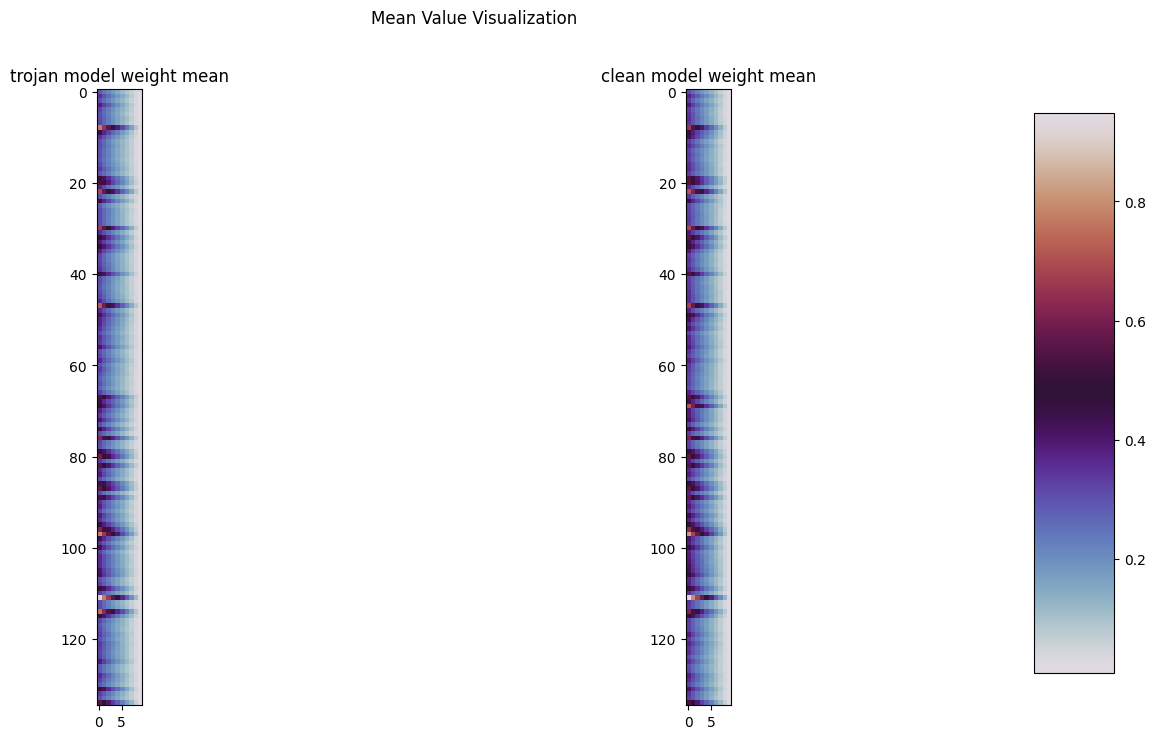

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
vmins, vmaxs = min(tmin, cmin), max(tmax, cmax)
axs[0].imshow(trojan_model_weights, vmin=vmins, vmax=vmaxs, cmap='twilight')
img = axs[1].imshow(clean_model_weights, vmin=vmins, vmax=vmaxs, cmap='twilight')
fig.subplots_adjust(right= 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax)
axs[0].set_title('trojan model weight mean')
axs[1].set_title('clean model weight mean')
fig.suptitle('Mean Value Visualization')

## Eigen Value

In [21]:
def extract_eigen(model):
    params = []
    num_param_per_layer = []
    min_shape = 1
    for param in model.parameters():
        if len(param.shape) > min_shape:
            reshaped_param = param.reshape(param.shape[0], -1)
            singular_values = torch.linalg.svd(reshaped_param, False).S
            squared_singular_values = torch.square(singular_values)
            ssv = squared_singular_values.tolist()
            params += ssv
            num_param_per_layer.append(len(ssv))
        return np.asarray(params), np.asarray(num_param_per_layer)

In [41]:
eigen_dict, eigen_shape_dict = [], []
for model_num in tqdm(range(MODEL_NUM)):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    model = torch.load(model_filepath)
    model_repr = OrderedDict({layer: tensor.numpy() for (layer, tensor) in model.state_dict().items()})
    fc1_weight = model_repr['fc1.weight'].T.reshape(135, 10, 10)
    _, s, _ = np.linalg.svd(fc1_weight)

    # e, es = extract_eigen(model)
    # eigen_dict[model_id] = e
    # eigen_shape_dict[model_id] = es
    eigen_dict.append(s.flatten())
eigen_dict = np.asarray(eigen_dict)

100%|██████████| 120/120 [00:00<00:00, 304.61it/s]


In [42]:
eigen_dict.shape

(120, 1350)

In [105]:
X, y = [], []
for model_num in range(MODEL_NUM):
    model_id = num_to_model_id(model_num)
    
    # x_weight = weight_dict[model_id][:507].tolist() + weight_dict[model_id][-17:].tolist()
    x_weight = weight_dict[model_id].tolist()
    x_eigen = eigen_dict[model_id][:100].tolist() + eigen_dict[model_id][-2:].tolist()
    X.append(x_weight + x_eigen)
    
    poisoned = METADATA[METADATA['model_name'] == model_id]['poisoned'].item()
    y.append(poisoned)
X = np.asarray(X)

# Visualization

In [6]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2, eps=.01):
    all_cross_entropy, all_accuracy = [], []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)

        if np.unique(y_train).shape[0] == 1 or np.unique(y_test).shape[0] == 1:
            continue
        
        clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test), eps=eps))
        all_accuracy.append(clf.score(X_test, y_test))
    return all_cross_entropy, all_accuracy

In [62]:
weight_dict_X.shape#, eigen_dict.shape

(120, 370)

In [50]:
weight_dict_X = np.concatenate([weight_dict_X, eigen_dict], axis=-1)
weight_dict_X.shape

(120, 2032)

In [47]:
clf = GradientBoostingClassifier(learning_rate=.01, n_estimators=500)
X_train, X_test, y_train, y_test = train_test_split(weight_dict_X, weight_dict_y, test_size=.2)
clf.fit(X_train, y_train);
clf.score(X_test, y_test)

0.6666666666666666

In [61]:
fe_X, fe_y = np.load('/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source/weight_with_agg_weight/fe_X.npy'), np.load('/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source/weight_with_agg_weight/fe_y.npy')

In [9]:
# clf = GradientBoostingClassifier(learning_rate=.018, n_estimators=560, min_samples_leaf=44, max_depth=3, max_features=656, min_samples_split=56)
clf = GradientBoostingClassifier(learning_rate=.01, n_estimators=500)
cen, acc = bootstrap_performance(X, y, clf, n=50, test_size=.2)
print(np.mean(cen), np.mean(acc))

0.7596724479721952 0.74


first layer weight only: cen - 0.6722151649906911; acc - 0.7125; (agg on axis=0, only weight)
0.6710706124944856 0.7167 (agg on axis=0, weight + bias)
first layer weight only: cen - 0.8338462676300622; acc - 0.5942; (agg on axis=-1, only weight)
first + last layer weight: cen - 0.7767968836885063; acc - 0.675; (agg on axis=0, only weight)
first + last layer weight: cen - 0.8614197942179671; acc - 0.5858; (agg on axis=-1, only weight)
first layer weight with eigen: cen - 0.6719570250977263; acc - 0.7025;
first + last layer weight with eigen: cen - 0.8070599903699808 ; acc - 0.6683;
first layer eigen only: 0.6462030035613026 0.7466666666666667;

visualize the matrix;
stats per layer, choose the front few eigen values from each layer - Net 3 and above, look at 1st and 2nd layer
Net 1 & Net 2  (or padding the addtional feature points to 0)

# Tune/Train Models

In [7]:
OUTPUT_FILEDIR = '/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source'

In [74]:
# clf = GradientBoostingClassifier(learning_rate=.013, n_estimators=750, max_depth= 4, max_features= 750, min_samples_leaf= 16, min_samples_split= 36)
clf = GradientBoostingClassifier(learning_rate=.01, n_estimators=500)
param={'max_depth': range(2, 5), 'min_samples_leaf': range(10, 201, 10), 'min_samples_split': range(10, 401, 20), 'max_features': range(25, 651, 25)}
# param = {'learning_rate':np.arange(.001, .0251, .001), 'n_estimators':range(400, 1201, 50)}
# param = {'learning_rate':[.01, .005, .015, .03, .0075], 'n_estimators':[650, 1300, 450, 225, 900]}
gsearch = GridSearchCV(estimator=clf, param_grid=param, scoring=['neg_log_loss', 'accuracy'], n_jobs=10, cv=5, refit=False);
gsearch.fit(X, y);

In [ ]:
gsearch_result = pd.DataFrame(gsearch.cv_results_).sort_values(by=['rank_test_neg_log_loss', 'rank_test_accuracy'])
gsearch_result.to_csv(os.path.join(OUTPUT_FILEDIR, 'gsearch_result_copy.csv'))

In [70]:
weight_dict_X.shape

(120, 952)

In [71]:
import joblib
# clf = GradientBoostingClassifier(learning_rate=.018, n_estimators=560, min_samples_leaf=44, max_depth=3, max_features=656, min_samples_split=56).fit(weight_dict_X, weight_dict_y)
# clf = GradientBoostingClassifier(learning_rate=.007, n_estimators=750, max_depth= 4, max_features= 360, min_samples_leaf= 2, min_samples_split= 22).fit(weight_dict_X, weight_dict_y)
clf = GradientBoostingClassifier(learning_rate=.013, n_estimators=750, max_depth= 4, max_features= 750, min_samples_leaf= 16, min_samples_split= 36).fit(weight_dict_X, weight_dict_y)
joblib.dump(clf, os.path.join(OUTPUT_FILEDIR, 'detector.joblib'))

['/scratch/jialin/cyber-pdf-dec2022/projects/weight_analysis/extracted_source/detector.joblib']

In [118]:
np.save(os.path.join(OUTPUT_FILEDIR, 'X.npy'), weight_dict_X)
np.save(os.path.join(OUTPUT_FILEDIR, 'y.npy'), weight_dict_y)

In [120]:
X, y = np.load(os.path.join(OUTPUT_FILEDIR, 'fe_X.npy')), np.load(os.path.join(OUTPUT_FILEDIR, 'fe_y.npy'))
X.shape, y.shape

((120, 682), (120,))

In [121]:
clf = GradientBoostingClassifier(learning_rate=.018, n_estimators=560, min_samples_leaf=44, max_depth=3, max_features=656, min_samples_split=56)
# clf = GradientBoostingClassifier(learning_rate=.01, n_estimators=500)
cen, acc = bootstrap_performance(X, y, clf, n=50, test_size=.2)
print(np.mean(cen), np.mean(acc))

0.6261368925796619 0.6691666666666667
